In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import cv2

from IPython.display import clear_output
import matplotlib.pyplot as plt


In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git
from tensorflow_examples.models.pix2pix import pix2pix

In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [ ]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE


In [ ]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)


In [ ]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels


In [ ]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)


In [10]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()


In [11]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [13]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


In [14]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [15]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]


In [16]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])


In [17]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))


In [18]:
EPOCHS = 30
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches)


Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 51s 375ms/step - accuracy: 0.7281 - loss: 0.6704 - val_accuracy: 0.8182 - val_loss: 0.5076
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 144ms/step - accuracy: 0.8848 - loss: 0.3059 - val_accuracy: 0.8882 - val_loss: 0.2962
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 0.8943 - loss: 0.2765 - val_accuracy: 0.8853 - val_loss: 0.3000
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 0.8984 - loss: 0.2623 - val_accuracy: 0.8701 - val_loss: 0.3397
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 0.9002 - loss: 0.2568 - val_accuracy: 0.8991 - val_loss: 0.2590
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 12s 212ms/step - accuracy: 0.9027 - loss: 0.2488 - val_accuracy: 0.8971 - val_loss: 0.2691
Epoch 7/30
 1/57 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.9082 - loss: 0.2335

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - accuracy: 0.9072 - loss: 0.2366 - val_accuracy: 0.8999 - val_loss: 0.2661
Epoch 8/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 0.9088 - loss: 0.2307 - val_accuracy: 0.9016 - val_loss: 0.2548
Epoch 9/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 0.9097 - loss: 0.2285 - val_accuracy: 0.8953 - val_loss: 0.2736
Epoch 10/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 0.9119 - loss: 0.2219 - val_accuracy: 0.8986 - val_loss: 0.2759
Epoch 11/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 0.9126 - loss: 0.2196 - val_accuracy: 0.9040 - val_loss: 0.2490
Epoch 12/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - accuracy: 0.9149 - loss: 0.2125 - val_accuracy: 0.9043 - val_loss: 0.2554
Epoch 13/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 0.9173 - loss: 0.2064 - val_accuracy: 0.8884 - val_loss: 0.2960
Epoch 14/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 0.9183 - loss: 0.2031 - val_accuracy: 0.9074 -

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step


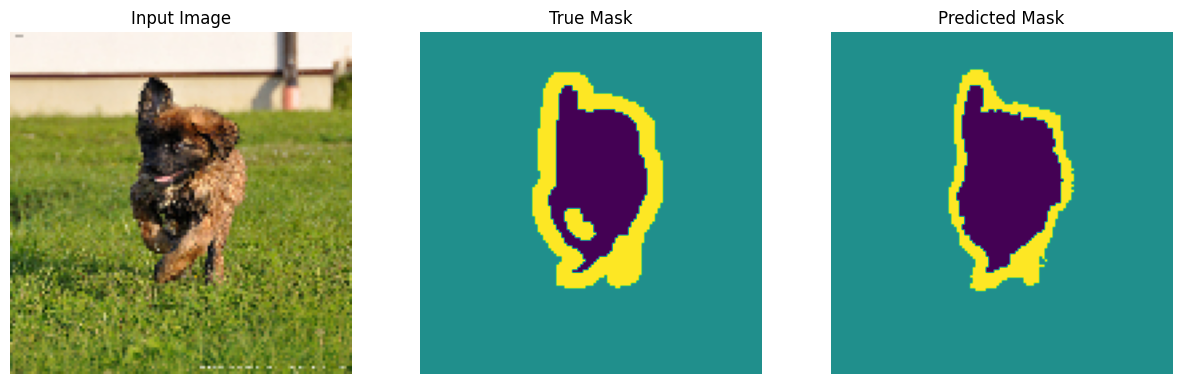

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


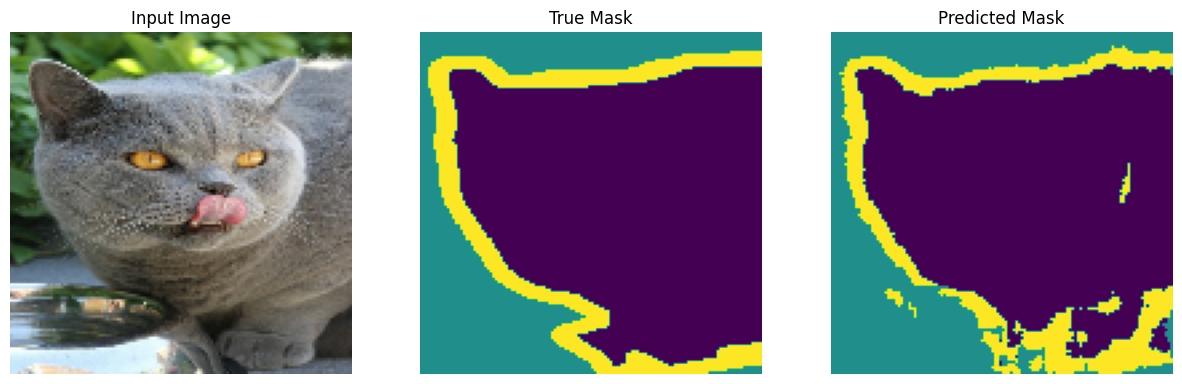

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


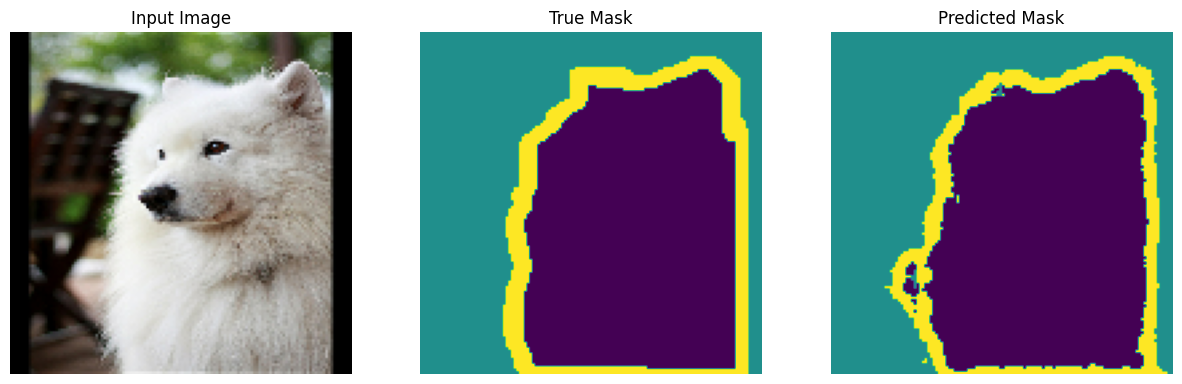

In [19]:
show_predictions(test_batches, 3)

In [149]:
def create_mask_for_image(image):
  image = tf.image.resize(image, (128, 128))
  image = tf.cast(image, tf.float32) / 255.0
  pred_mask = model.predict(image[tf.newaxis, ...])
  pred_mask = create_mask(pred_mask)
  pred_mask = tf.where(pred_mask == 1, [0, 255, 0], pred_mask) # Change mask color to green
  return pred_mask


In [30]:
def create_mask_for_image(image):
  image = tf.image.resize(image, (128, 128))
  image = tf.cast(image, tf.float32) / 255.0
  pred_mask = model.predict(image[tf.newaxis, ...])
  pred_mask = create_mask(pred_mask)
  pred_mask = tf.image.resize(pred_mask, (image.shape[0], image.shape[1]))
  pred_mask = tf.where(pred_mask == [0,255,0], 1, pred_mask)
  blended_image = tf.add(tf.cast(image, tf.float32), tf.cast(pred_mask, tf.float32))
  return blended_image


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


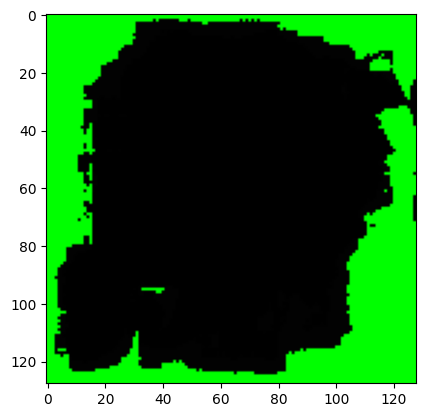

In [150]:
my_image = plt.imread('/content/cropped_image.jpg')
my_mask = create_mask_for_image(my_image)
plt.imshow(my_mask)

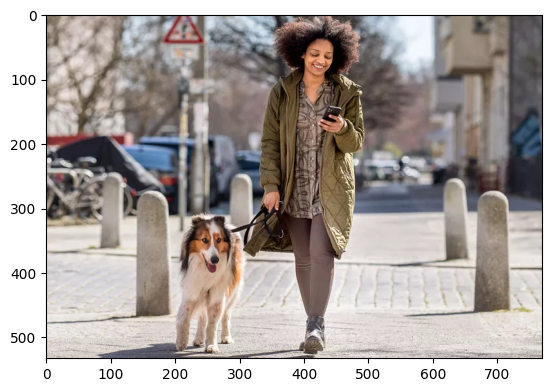

In [151]:
original_img=cv2.imread('/content/person-walking-dog-1389949056-770x533-1_jpg.jpg')
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
plt.imshow(original_img)

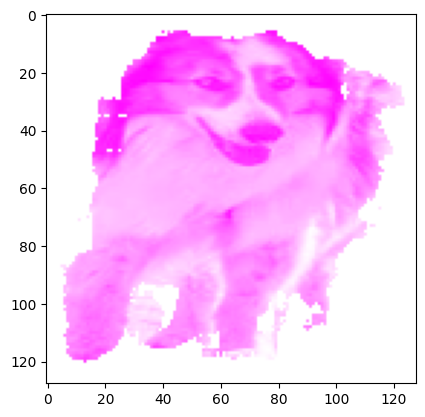

In [58]:
plt.imshow(my_mask)

In [156]:
original_img=cv2.imread('/content/person-walking-dog-1389949056-770x533-1_jpg.jpg')
original_img=cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

In [152]:
x1, y1, x2, y2 = 190, 300, 320, 520
resized_mask = tf.image.resize(my_mask, (y2-y1, x2-x1))

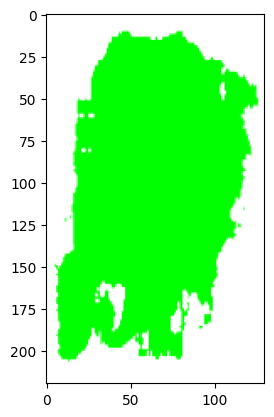

In [129]:
plt.imshow(resized_mask)

In [153]:
resized_mask_np = resized_mask.numpy().astype(np.uint8)

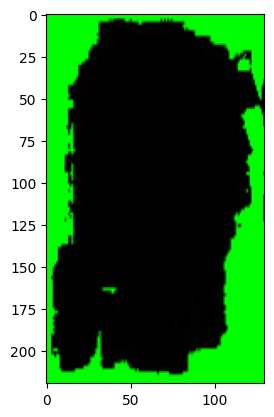

In [154]:
plt.imshow(resized_mask_np)

In [163]:
original_img=cv2.imread('/content/person-walking-dog-1389949056-770x533-1_jpg.jpg')
original_img=cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

In [165]:
def mask_original(original_img,x1,y1,x2,y2,resized_mask_np):
  for i in range(y2-y1):
    for j in range(x2-x1):
      if np.all(resized_mask_np[i,j] == [0,0,0]):
        original_img[y1+i,x1+j,:] = resized_mask_np[i,j,:]*255
  return original_img


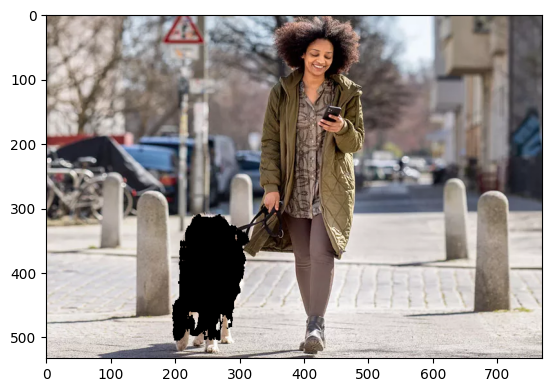

In [166]:
plt.imshow(mask_original(original_img,x1,y1,x2,y2,resized_mask_np))